# ACLO Notebook
Goal: load raw check-ins → build daily dataset → quick sanity checks


In [28]:
#Install packages for the project
#!pip install pandas numpy seaborn matplotlib scikit-learn scipy networkx 

Import the required modules

In [29]:
# Import the required building blocks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn import preprocessing
from scipy import stats

# Number of visits per time of day for all of the Check-in-time data



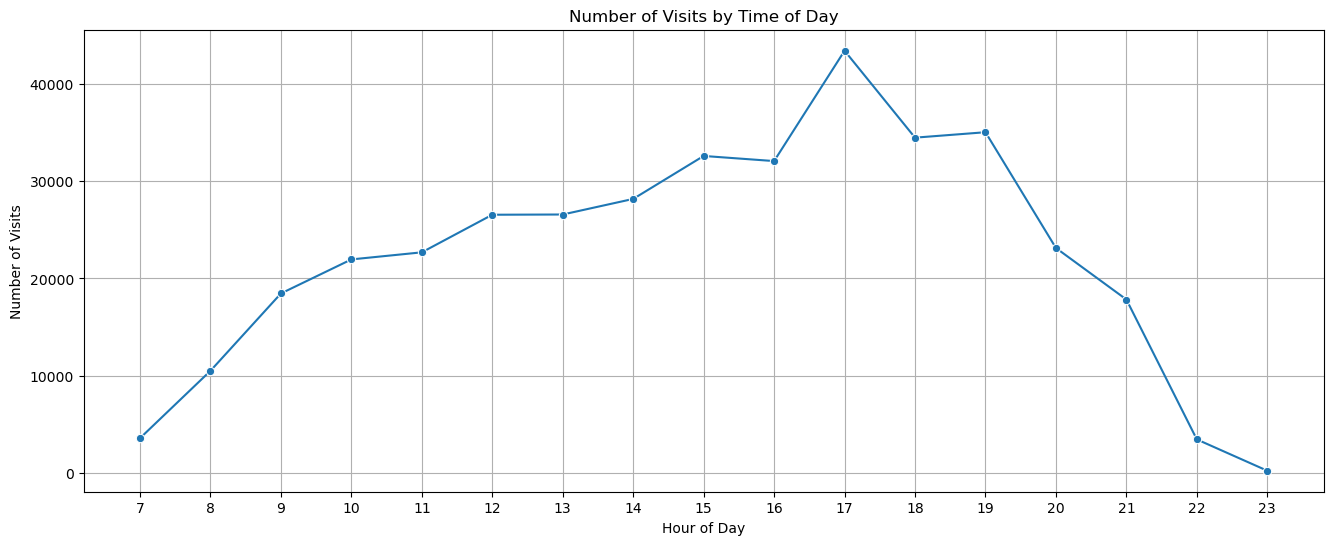

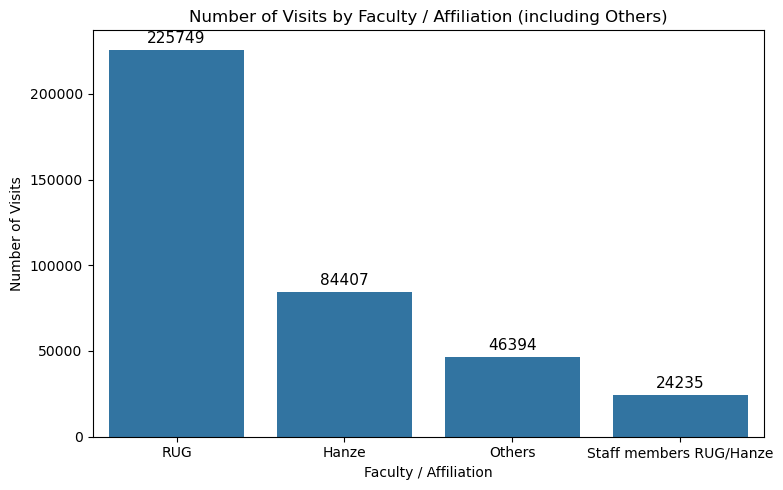

In [30]:

# Read the data from the specified file
df_visits = pd.read_csv('data/Check-in times/Check-in-times_sheet_2017-2021 kaikki checkin timet yhes.csv')

# Parse the check-in time column (assuming it's named like in your previous df)
# Find the column that contains 'date' in its name (case-insensitive)
time_col = [col for col in df_visits.columns if 'date' in col.lower()][0]

# Convert to datetime and extract hour
df_visits['hour'] = pd.to_datetime(df_visits[time_col], errors='coerce').dt.hour

# Count visits per hour
visits_per_hour = df_visits['hour'].value_counts().sort_index()

# Plot
plt.figure(figsize=(16,6))
sns.lineplot(x=visits_per_hour.index, y=visits_per_hour.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Visits')
plt.title('Number of Visits by Time of Day')
plt.xticks(range(7, 24))
plt.grid(True)
plt.show()
# Only keep visits from RUG, Hanze, or Medewerkers RUG/Hanze
faculty_labels = ['RUG', 'Hanze', 'Staff member RUG/Hanze', 'Staff members RUG/Hanze']
faculty_col = 'Lid id '  # already detected

# Normalize values for matching (strip and lower)
def normalize_faculty(val):
    if pd.isnull(val):
        return None
    val = str(val).strip().lower()
    if val == 'rug':
        return 'RUG'
    elif val == 'hanze':
        return 'Hanze'
    elif 'medewerker' in val and 'hanze' in val and 'rug' in val:
        return 'Staff members RUG/Hanze'
    return None
df_visits['faculty_group'] = df_visits[faculty_col].apply(normalize_faculty)

filtered = df_visits[df_visits['faculty_group'].isin(['RUG', 'Hanze', 'Staff members RUG/Hanze'])]

# Add "Others" group for visits not matching the three main faculty groups
filtered_faculties = ['RUG', 'Hanze', 'Staff members RUG/Hanze']
df_visits['faculty_group_full'] = df_visits['faculty_group'].where(
    df_visits['faculty_group'].isin(filtered_faculties), 'Others'
)

faculty_full_counts = df_visits['faculty_group_full'].value_counts().reindex(
    ['RUG', 'Hanze', 'Others', 'Staff members RUG/Hanze']
).fillna(0)

plt.figure(figsize=(8,5))
sns.barplot(x=faculty_full_counts.index, y=faculty_full_counts.values)
plt.xlabel('Faculty / Affiliation')
plt.ylabel('Number of Visits')
plt.title('Number of Visits by Faculty / Affiliation (including Others)')
for i, count in enumerate(faculty_full_counts.values):
    plt.text(i, count + max(faculty_full_counts.values)*0.01, int(count), ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()



# Cardholder data

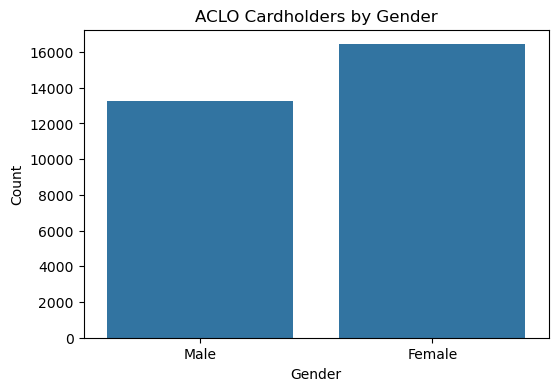

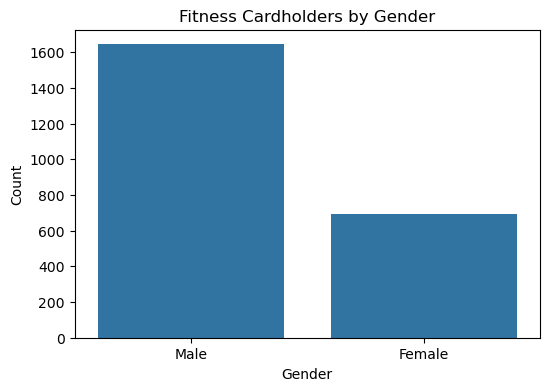

In [31]:
cardholders_full = pd.read_csv('data/Cardholders/Kaikki membership tyypit vuodet 2020-2022.csv')
cardholders_full.describe()

# Separate ACLO and Fitness cardholders
is_aclo = cardholders_full['Description'].str.contains('ACLO', case=False, na=False)
is_fitness = cardholders_full['Description'].str.contains('Fitness', case=False, na=False)

aclo_cardholders = cardholders_full[is_aclo]
fitness_cardholders = cardholders_full[is_fitness]

# Plot count by gender for ACLO cardholders
aclo_gender_counts = pd.Series({
    'Male': aclo_cardholders['Gender Male'].notnull().sum(),
    'Female': aclo_cardholders['Gender Female'].notnull().sum()
})
plt.figure(figsize=(6,4))
sns.barplot(x=aclo_gender_counts.index, y=aclo_gender_counts.values)
plt.title('ACLO Cardholders by Gender')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()

# Plot count by gender for Fitness cardholders
fitness_gender_counts = pd.Series({
    'Male': fitness_cardholders['Gender Male'].notnull().sum(),
    'Female': fitness_cardholders['Gender Female'].notnull().sum()
})
plt.figure(figsize=(6,4))
sns.barplot(x=fitness_gender_counts.index, y=fitness_gender_counts.values)
plt.title('Fitness Cardholders by Gender')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()





# Correlation Matrix

# Reading the source file

In [32]:
#checking the data types
df.dtypes
print(df.columns.tolist())


NameError: name 'df' is not defined

# Check in times compared to academic caldenders



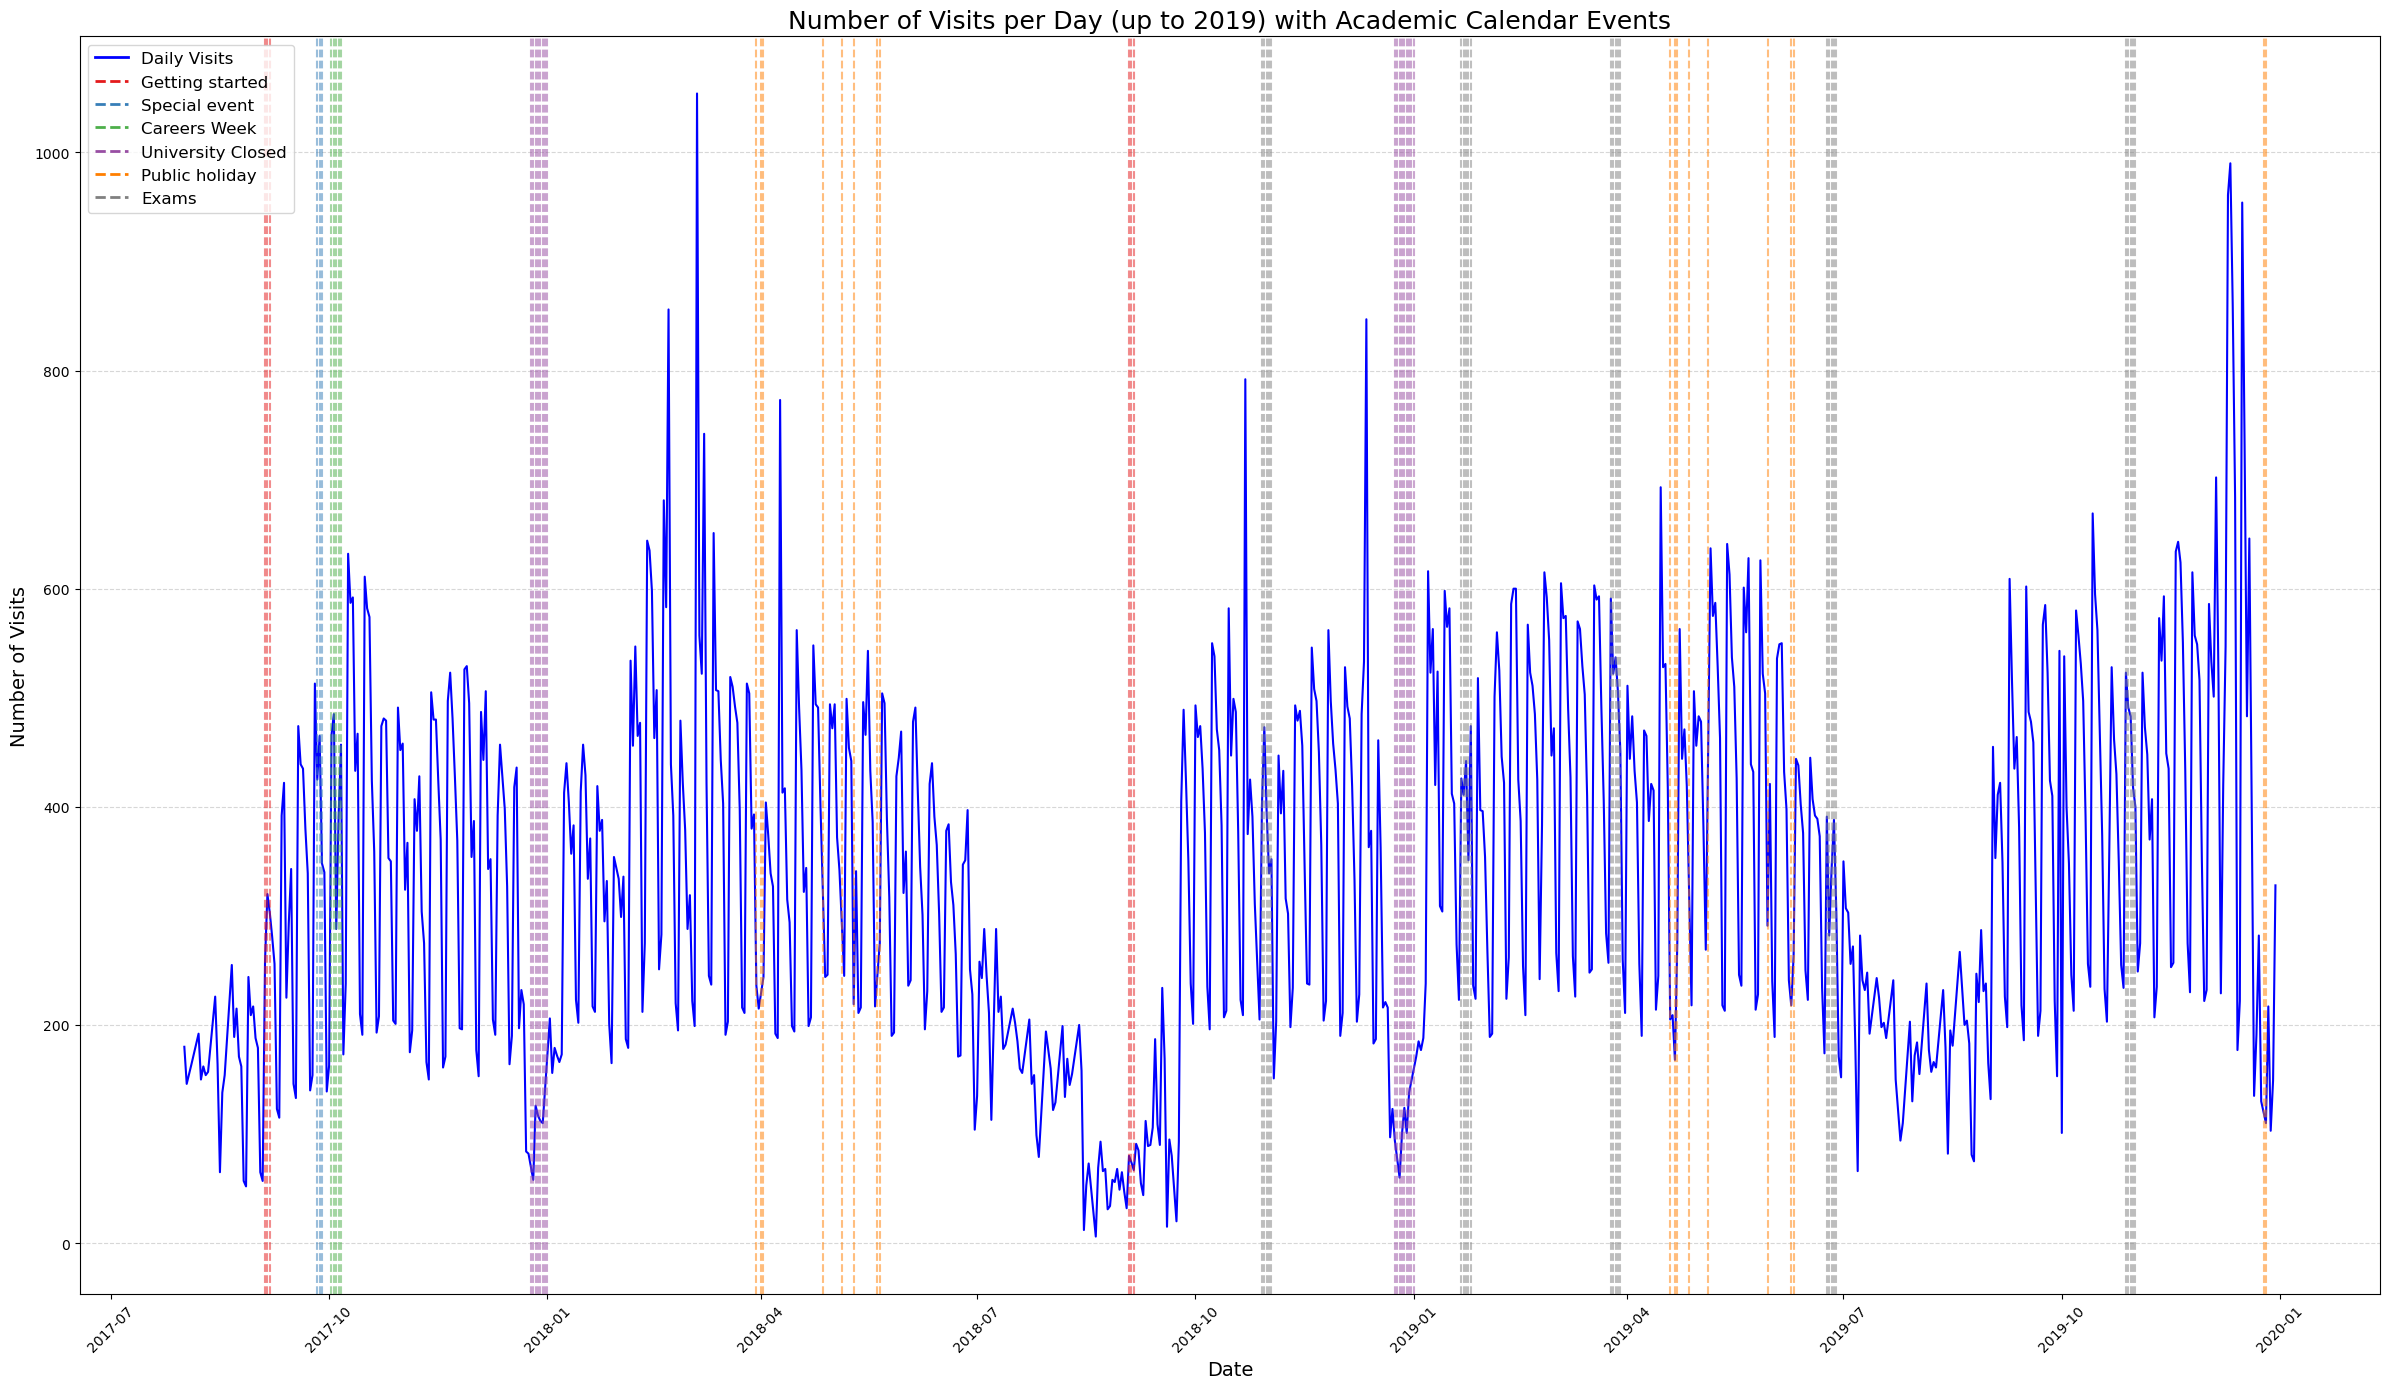

In [ ]:
from matplotlib.lines import Line2D

# Add color for Exam Week if missing
if 'Exams' not in event_type_colors:
    event_type_colors['Exams'] = (0.5, 0.5, 0.5)  # gray or pick any color you like

plt.figure(figsize=(24, 14))
sns.lineplot(x=visits_per_day_2019.index, y=visits_per_day_2019.values, label='Daily Visits', color='blue')

calendar_events = calendar_df[calendar_df['date'] <= pd.to_datetime('2019-12-31')]
plt.subplots_adjust(left=0.07, right=0.99, top=0.97, bottom=0.13)
for _, row in calendar_events.iterrows():
    event_date = row['date']
    event_name = row['event_name']
    event_type = row['event_type']
    color = event_type_colors.get(event_type, 'orange')
    plt.axvline(x=event_date, color=color, alpha=0.5, linestyle='--')
    
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Visits', fontsize=14)
plt.title('Number of Visits per Day (up to 2019) with Academic Calendar Events', fontsize=18)
plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)

# Custom legend for event types
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Daily Visits')]
for event_type, color in event_type_colors.items():
    legend_elements.append(Line2D([0], [0], color=color, lw=2, linestyle='--', label=event_type))
plt.legend(handles=legend_elements, fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()


# Effect of Covid-19 on the visitor numbers


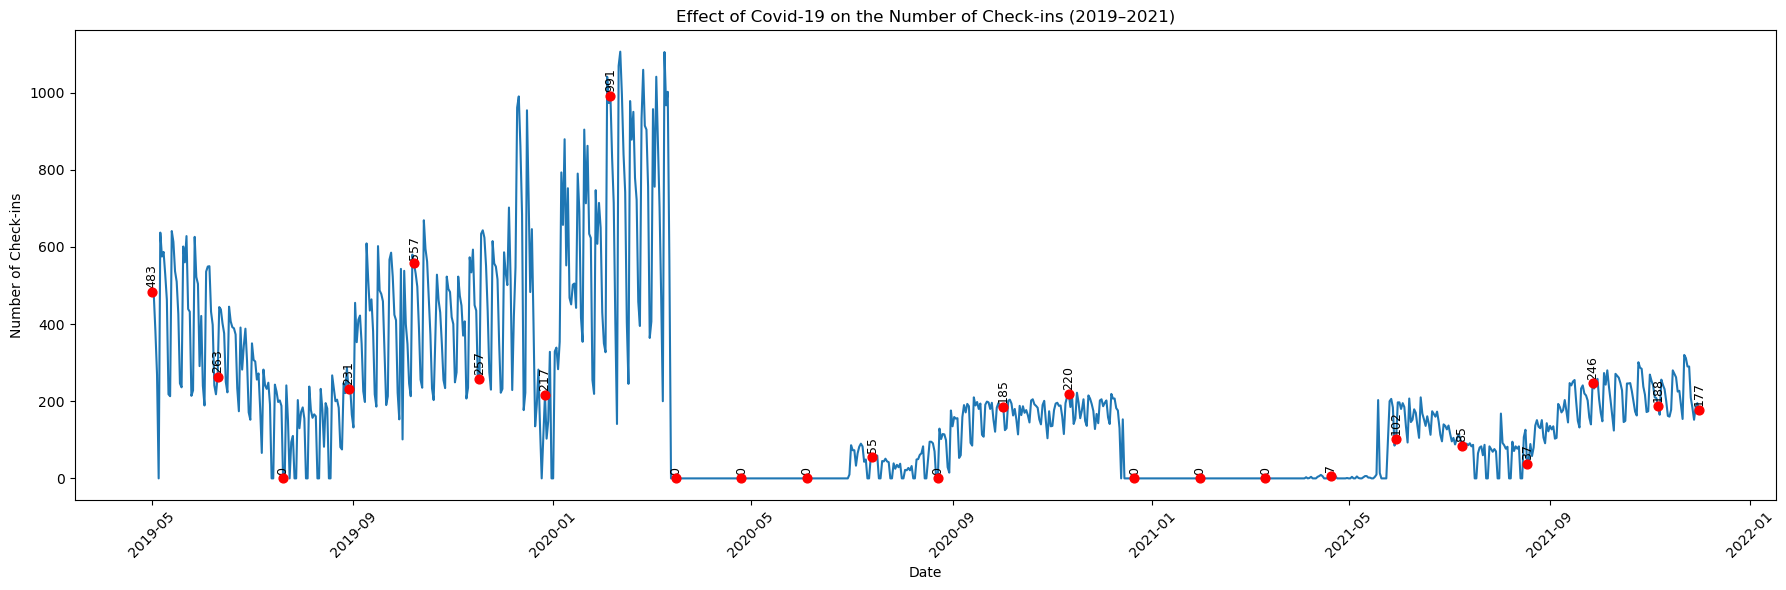

In [33]:
# --- Build visits_per_day (adjust df_visits / time_col if yours differ) ---
# Guess the datetime column
time_col = [c for c in df_visits.columns if ('date' in c.lower() or 'time' in c.lower())][0]
df_visits[time_col] = pd.to_datetime(df_visits[time_col], errors='coerce')

# Count check-ins per day -> Series with DatetimeIndex
visits_per_day = (
    df_visits
      .dropna(subset=[time_col])
      .set_index(time_col)
      .resample('D')
      .size()
)

# --- Filter from 2019-05-01 (match types with Timestamp) ---
start = pd.Timestamp('2019-05-01')
visits_2019_on = visits_per_day.loc[visits_per_day.index >= start]

# --- Plot ---
plt.figure(figsize=(18, 6))
sns.lineplot(x=visits_2019_on.index, y=visits_2019_on.values)

# Add labels roughly every 40th point and the last one
for idx, (date, count) in enumerate(zip(visits_2019_on.index, visits_2019_on.values)):
    if idx % 40 == 0 or idx == len(visits_2019_on) - 1:
        plt.scatter(date, count, s=40, zorder=5, color='red')
        plt.text(date, count + 10, str(int(count)), ha='center', va='bottom',
                 fontsize=9, color='black', rotation=90)

plt.xlabel('Date')
plt.ylabel('Number of Check-ins')
plt.title('Effect of Covid-19 on the Number of Check-ins (2019–2021)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
